 # COVID-19 mRNA Vaccine Degradation Prediction


In [1]:
import gc

import numpy as np
import pandas as pd
import sys

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras.models import Model

from sklearn.preprocessing import LabelEncoder
from tensorflow import keras


In [2]:
#System Check
print("Python Version: ", sys.version)
print("TensorFlow Version: ", tf.__version__)
print("# GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

Python Version:  3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]
TensorFlow Version:  2.3.1
# GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [4]:
#Tensorflow path check
tf

<module 'tensorflow' from 'C:\\Users\\avaki\\anaconda3\\lib\\site-packages\\tensorflow\\__init__.py'>

## Load and Preprocess Data

In [5]:
train_df = pd.read_json('train.json', lines=True)
test_df = pd.read_json('test.json', lines=True)
sample_df = pd.read_csv('sample_submission.csv')

In [6]:
train_df.head()

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


In [7]:
sample_df.head()

,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.0,0.0,0.0,0.0,0.0
1,id_00073f8be_1,0.0,0.0,0.0,0.0,0.0
2,id_00073f8be_2,0.0,0.0,0.0,0.0,0.0
3,id_00073f8be_3,0.0,0.0,0.0,0.0,0.0
4,id_00073f8be_4,0.0,0.0,0.0,0.0,0.0


In [8]:
train_df.columns

Index(['index', 'id', 'sequence', 'structure', 'predicted_loop_type',
       'signal_to_noise', 'SN_filter', 'seq_length', 'seq_scored',
       'reactivity_error', 'deg_error_Mg_pH10', 'deg_error_pH10',
       'deg_error_Mg_50C', 'deg_error_50C', 'reactivity', 'deg_Mg_pH10',
       'deg_pH10', 'deg_Mg_50C', 'deg_50C'],
      dtype='object')

In [9]:
train_df["sequence"].str.split("").apply(lambda x: (np.unique(x), len(x)))

0       ([, A, C, G, U], 109)
1       ([, A, C, G, U], 109)
2       ([, A, C, G, U], 109)
3       ([, A, C, G, U], 109)
4       ([, A, C, G, U], 109)
                ...          
2395    ([, A, C, G, U], 109)
2396    ([, A, C, G, U], 109)
2397    ([, A, C, G, U], 109)
2398    ([, A, C, G, U], 109)
2399    ([, A, C, G, U], 109)
Name: sequence, Length: 2400, dtype: object

In [10]:
np.unique(train_df["seq_length"].values)

array([107], dtype=int64)

In [11]:
feature_columns = ['sequence', 'structure', 'predicted_loop_type']
target_columns = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

In [12]:
train_df.head()

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


In [13]:
label_encoders = dict()
for column in feature_columns:
    encoder = LabelEncoder()
    encoder.fit(list(set(train_df[column].apply(list).sum())))
    label_encoders[column]=encoder
    del encoder
    gc.collect()
    

In [14]:
def transform_(df:pd.DataFrame, label_encoders:dict):
    for column in feature_columns:
        df[column+"_n"] = df[column].apply(lambda seq: label_encoders[column].transform(list(seq)))        
    return df

In [15]:
train_df = transform_(train_df, label_encoders)
test_df = transform_(test_df, label_encoders)

feature_columns_n = [column for column in train_df.columns if "e_n" in column];
feature_columns_n

train_x = np.array(train_df[feature_columns_n].values.tolist()).transpose((0, 2, 1))
train_y = np.array(train_df[target_columns].values.tolist()).transpose((0, 2, 1))

## Build and Train Model

In [26]:
def build_model(seq_len=107, pred_len=68, dropout=0.5, embed_dim=100, hidden_dim=128):
    
    inputs = L.Input(shape = (seq_len, 3))
    
    inputs_as = L.Lambda(lambda x: tf.split(x, inputs.shape[-1], axis=-1))(inputs)
    #inputs_as = L.Lambda(lambda x: [tf.expand_dims(x[:, :, i], -1) for i in range(inputs.shape[-1])])(inputs)
    print(len(inputs_as), inputs_as[0].shape)
    
    
    embeddings = []
    for i, (inp_a, col)in enumerate(zip(inputs_as, feature_columns)):
        
        embedding = L.Embedding(input_dim = len(label_encoders[col].classes_),
                               output_dim = embed_dim)(inp_a)
        embedding = L.Reshape((-1, embedding.shape[2] * embedding.shape[3]))(embedding)
        
        embeddings.append(embedding)
        
    embed_cat = L.Concatenate()(embeddings)
    
    cat = L.Bidirectional(L.LSTM(hidden_dim, dropout=dropout, return_sequences=True))(embed_cat)

    
    cat = cat[:, :pred_len]
    
    cat = L.Dense(64, activation="relu")(cat)
    dense = L.Dense(5, activation='linear')(cat)
    
    model = Model(inputs=inputs, outputs = dense)
    model.compile(loss="mse", optimizer='adam', metrics = 'accuracy')
        
    return model
        

In [27]:
model = build_model()
model.summary()

3 (None, 107, 1)
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 107, 3)]     0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               [(None, 107, 1), (No 0           input_3[0][0]                    
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 107, 1, 100)  400         lambda_2[0][0]                   
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 107, 1, 100)  300         lambda_2[0][1]                   
______________________________________________________________________

In [28]:
history = model.fit(train_x, train_y, 
          batch_size=64,
          epochs=70,
          callbacks=[
              tf.keras.callbacks.ReduceLROnPlateau(),
              #tf.keras.callbacks.ModelCheckpoint('model.h5')
          ],
          validation_split=0.3)

Epoch 1/70
27/27 [==============================] - 2s 57ms/step - loss: 0.9637 - accuracy: 0.2586 - val_loss: 0.8415 - val_accuracy: 0.3231
Epoch 2/70
27/27 [==============================] - 1s 26ms/step - loss: 0.8828 - accuracy: 0.3088 - val_loss: 0.8056 - val_accuracy: 0.3407
Epoch 3/70
27/27 [==============================] - 1s 24ms/step - loss: 0.8628 - accuracy: 0.3303 - val_loss: 0.7909 - val_accuracy: 0.3503
Epoch 4/70
27/27 [==============================] - 1s 24ms/step - loss: 0.8518 - accuracy: 0.3444 - val_loss: 0.7792 - val_accuracy: 0.3372
Epoch 5/70
27/27 [==============================] - 1s 23ms/step - loss: 0.8400 - accuracy: 0.3399 - val_loss: 0.7689 - val_accuracy: 0.3596
Epoch 6/70
27/27 [==============================] - 1s 24ms/step - loss: 0.8326 - accuracy: 0.3481 - val_loss: 0.7653 - val_accuracy: 0.3602
Epoch 7/70
27/27 [==============================] - 1s 24ms/step - loss: 0.8281 - accuracy: 0.3541 - val_loss: 0.7647 - val_accuracy: 0.3660
Epoch 8/70
27

Epoch 59/70
27/27 [==============================] - 1s 23ms/step - loss: 0.6969 - accuracy: 0.4078 - val_loss: 0.7267 - val_accuracy: 0.4126
Epoch 60/70
27/27 [==============================] - 1s 23ms/step - loss: 0.6959 - accuracy: 0.4065 - val_loss: 0.7281 - val_accuracy: 0.4117
Epoch 61/70
27/27 [==============================] - 1s 23ms/step - loss: 0.6940 - accuracy: 0.4059 - val_loss: 0.7277 - val_accuracy: 0.4132
Epoch 62/70
27/27 [==============================] - 1s 24ms/step - loss: 0.6930 - accuracy: 0.4057 - val_loss: 0.7281 - val_accuracy: 0.4121
Epoch 63/70
27/27 [==============================] - 1s 24ms/step - loss: 0.6935 - accuracy: 0.4061 - val_loss: 0.7299 - val_accuracy: 0.4126
Epoch 64/70
27/27 [==============================] - 1s 24ms/step - loss: 0.6914 - accuracy: 0.4061 - val_loss: 0.7296 - val_accuracy: 0.4131
Epoch 65/70
27/27 [==============================] - 1s 24ms/step - loss: 0.6912 - accuracy: 0.4063 - val_loss: 0.7295 - val_accuracy: 0.4132
Epoch 

## Analysis

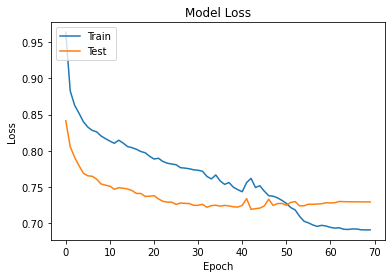

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

If your training loss is much lower than validation loss then this means the network might be overfitting . Solutions to this are to decrease your network size, or to increase dropout. For example you could try dropout of 0.5 and so on. If your training/validation loss are about equal then your model is underfitting.

When comparing validation loss and training loss - when do we know we have a good ratio? Should we get validation loss to be lower than training loss?


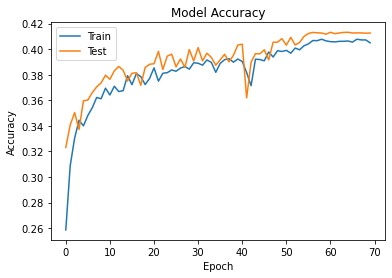

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

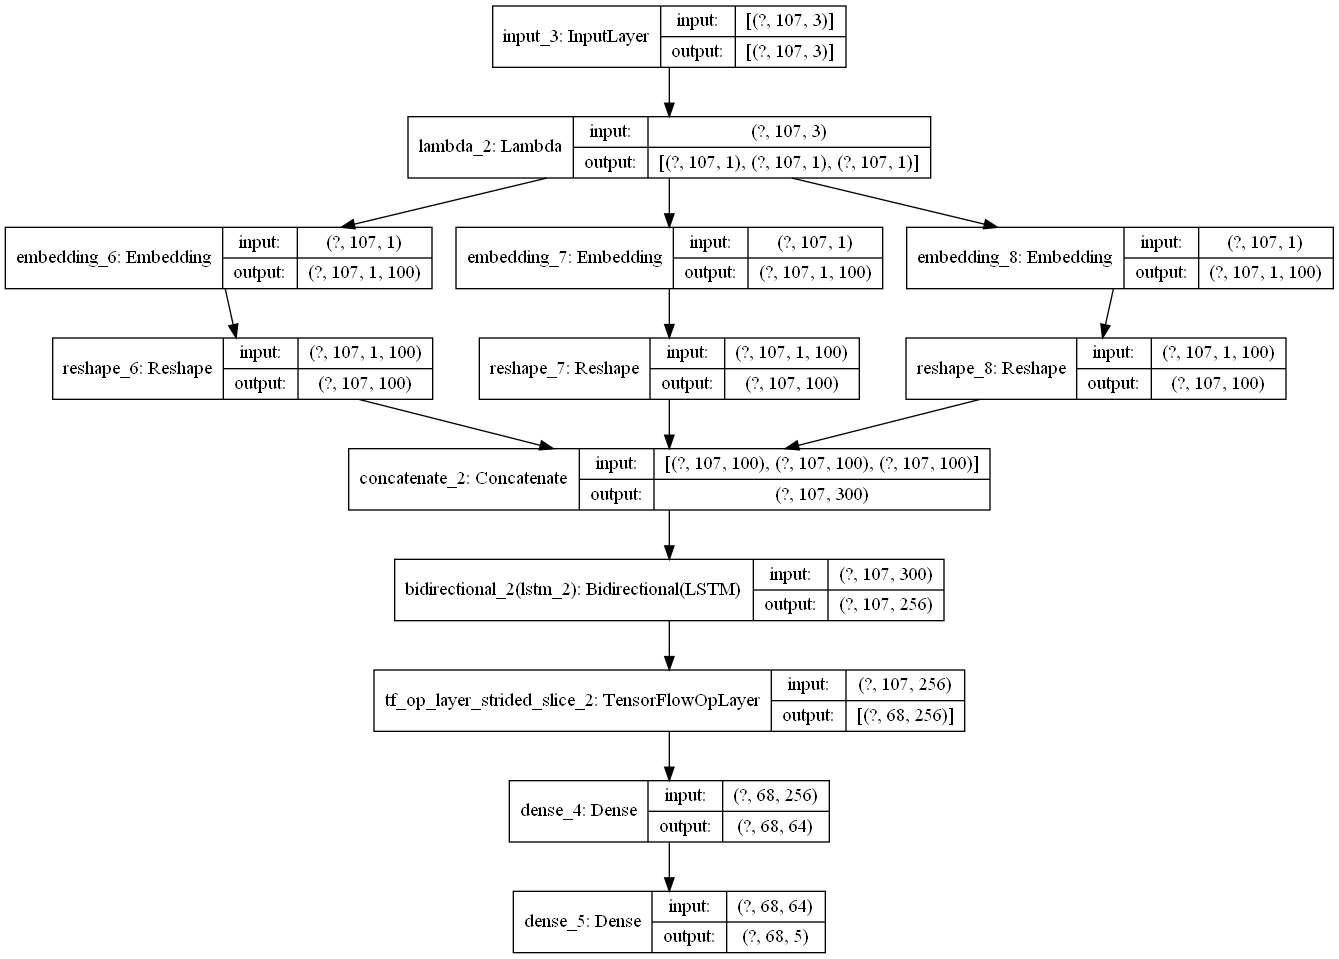

In [31]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Load Models and Make Predictions

In [32]:
public_df = test_df.query("seq_length == 107").copy()
private_df = test_df.query("seq_length == 130").copy()

public_df = transform_(public_df, label_encoders)
private_df = transform_(private_df, label_encoders)

public_test_x = np.array(public_df[feature_columns_n].values.tolist()).transpose((0, 2, 1))
private_test_x = np.array(private_df[feature_columns_n].values.tolist()).transpose((0, 2, 1))

In [33]:
model_short = build_model(seq_len=107, pred_len=107)
model_long = build_model(seq_len=130, pred_len=130)

model_short.set_weights(model.get_weights())
model_long.set_weights(model.get_weights())

public_preds = model_short.predict(public_test_x, verbose=1)
private_preds = model_long.predict(private_test_x, verbose=1)

3 (None, 107, 1)
3 (None, 130, 1)
94/94 [==============================] - 1s 7ms/step


In [34]:
print(public_preds.shape, private_preds.shape)

(629, 107, 5) (3005, 130, 5)


## Postprocess and Submit

In [35]:
preds_ls = []

for df, preds in [(public_df, public_preds), (private_df, private_preds)]:
    for i, uid in enumerate(df.id):
        single_pred = preds[i]

        single_df = pd.DataFrame(single_pred, columns=target_columns)
        single_df['id_seqpos'] = [f'{uid}_{x}' for x in range(single_df.shape[0])]

        preds_ls.append(single_df)

preds_df = pd.concat(preds_ls)

In [36]:
preds_df.head()

,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C,id_seqpos
0,0.762279,0.679095,2.103237,0.606563,0.638129,id_00073f8be_0
1,2.107473,3.214641,4.081809,3.149789,2.692912,id_00073f8be_1
2,1.086337,0.656302,0.667428,0.786195,0.757369,id_00073f8be_2
3,1.250152,1.235228,1.273560,1.540339,1.454312,id_00073f8be_3
4,0.883051,0.653325,0.690024,0.796596,0.847302,id_00073f8be_4


In [37]:
submission = sample_df[['id_seqpos']].merge(preds_df, on=['id_seqpos'])
submission.to_csv('submission1.csv', index=False)